# 7. Partial Differential Equations

References:
* Svein Linge & Hans Petter Langtangen: Programming for Computations – Python. Springer (2016). 
    - Chapter 5: Solving Partial Differential Equations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Partial derivative
For a function with multiple inputs $f(x_1,...,x_n)$, a *partial derivative* is the derivative with respect to an input $x_i$ while other inputs are held constant.
$$\frac{\partial f(x_1,...,x_n)}{\partial x_i}
 = \lim_{\Delta x \rightarrow 0} \frac{f(x_1,...,x_i+\Delta x,...,x_n) - f(x_1,...,x_i,...,x_n)}{\Delta x}$$
 
For example, for 
$$ f(x,y) = e^{x} \sin y, $$
partial derivatives are
$$ \frac{\partial f(x,y)}{\partial x} = e^{x} \sin y $$
$$ \frac{\partial f(x,y)}{\partial y} = e^{x} \cos y $$

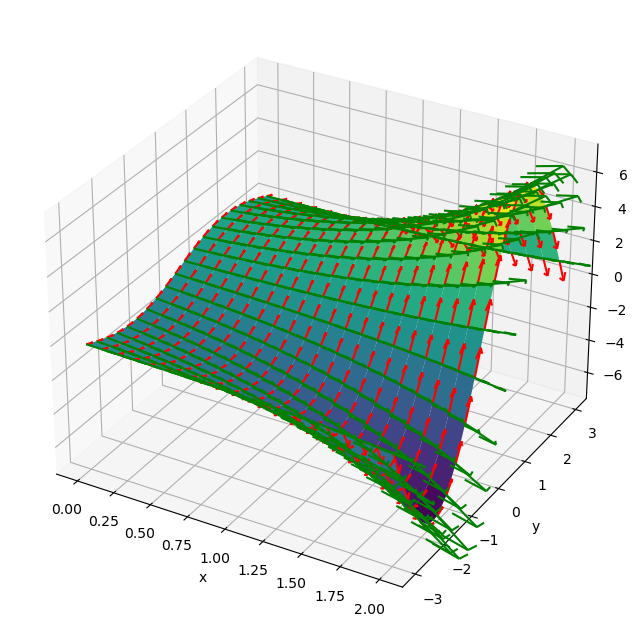

In [2]:
x, y = np.meshgrid(np.linspace(0, 2, 20), np.linspace(-3, 3, 20))
f = np.exp(x) * np.sin(y)
dfdx = np.exp(x) * np.sin(y)
dfdy = np.exp(x) * np.cos(y)
# 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(x, y, f, cmap='viridis')
x0 = np.zeros_like(x)
x1 = np.ones_like(x)
ax.quiver(x, y, f, x1, x0, dfdx, color='g', length=0.2)
ax.quiver(x, y, f, x0, x1, dfdy, color='r', length=0.2)
plt.xlabel('x'); plt.ylabel('y');

## Partial Differential Equation (PDE)
A *partial differential equation (PDE)* is an equation that includes partial derivatives $\frac{\partial f(x_1,...,x_n)}{\partial x_i}$ of an unknown function $f(x_1,...,x_n)$.

A typical case is a function in space and time $y(x,t).$

A simple example is the *diffusion equation* (or heat equation)
$$ \frac{\partial y(x,t)}{\partial t} = D \frac{\partial^2 y(x,t)}{\partial x^2} + g(y,x,t)  $$
that describes the evolution of concentration (or temperature) $y$ in space $x$ and time $t$ with input $g(y,x,t)$ and the diffusion coefficient $D$.

## Analytic Solution of PDE
For a diffusion equation without input
$$ \frac{\partial y}{\partial t} = D \frac{\partial^2 y}{\partial x^2}, $$
the solution is given by *separation of variables*.

By assuming that the solution is a product of temporal and spatial components $y(x,t) = u(t) v(x)$, the PDE becomes 
$$ \frac{\partial u(t)}{\partial t} v(x)= D u(t) \frac{\partial^2 v(x)}{\partial x^2} $$
$$ \frac{1}{Du(t)}\frac{\partial u(t)}{\partial t} = \frac{1}{v(x)}\frac{\partial^2 v(x)}{\partial x^2} $$
For this equation to hold for any $t$ and $x$, a possible solution is for both sides to be a constant $C$. Then we have two separate ODEs:
$$ \frac{du(t)}{dt} = C D u(t) $$
$$ \frac{d^2v(x)}{dx^2} = C v(x) $$
for which we know analitic solutions.  

By setting $C=-b^2\le 0$, we have
$$ u(t) = C_0 e^{-b^2 Dt}, $$
$$ v(x) = C_1 \sin bx + C_2 \cos bx. $$

Thus we have a solution
$$ y(x,t) = e^{-b^2 Dt}( C_1 \sin bx + C_2 \cos bx) $$
where $b$, $C_1$ and $C_2$ are determined by the initial condition $y(x,0)$.  
The equation tells us that higher spatial frequency components decay quiker.

### Boundary condition
For uniquely specifying a solution of a PDE in a bounded area, e.g., $x_0<x<x_1$, we need to specify either 
* the value $y(x,t)$ (Dirichlet boundary condition) 
* or the derivative $\frac{\partial y(x,t)}{\partial x}$ (Neumann boundary condition)  

at the boundary $x_0$ and $x_1$ to uniquely determine the solution.

## From PDE to ODE
The standard way of dealing with space and time on a digital computer is to discretize them. For a PDE 
$$ \frac{\partial y}{\partial t} = D \frac{\partial^2 y}{\partial x^2} + g(y,x,t), $$
defined in a range $x_0 \le x \le x_0+L$, we consider a spatial discretization by $\Delta x = L/N$ 
$$ x_i = x_0 + i\Delta x $$
$(i=1,...,N)$ and
$$ y_i(t) = y(x_i,t).$$

Then the PDE can be approximated by a set of ODEs
$$ \frac{dy_i}{dt} = D \frac{y_{i+1}-2y_i+y_{i-1}}{\Delta x^2} + g(y_i,x_i,t). $$


## Euler method
First, let us solve the converted ODE by Eulre method.

In [3]:
def euler(f, y0, dt, n, args=()):
    """f: righthand side of ODE dy/dt=f(y,t)
        y0: initial condition y(0)=y0
        dt: time step
        n: iteratons
        args: parameter for f(y,t,*args)"""
    d = np.array([y0]).size  ## state dimension
    y = np.zeros((n+1, d))
    y[0] = y0
    t = 0
    for k in range(n):
        y[k+1] = y[k] + f(y[k], t, *args)*dt
        t = t + dt
    return y

In [4]:
def diff1D(y, t, x, D, inp=None):
    """1D Diffusion equaiton with constant boundary condition
    y: state vector
    t: time
    x: positions
    D: diffusion coefficient
    input: function(y,x,t)"""
    dx = x[1] - x[0]  # space step
    # shift to left and right and subtract
    d2ydx2 = (y[:-2] -2*y[1:-1] + y[2:])/dx**2
    # add 0 to both ends for Dirichlet boundary condition
    d2ydx2 = np.hstack((0, d2ydx2, 0))
    if inp == None:
        return D*d2ydx2
    else:
        return D*d2ydx2 + inp(y, x, t)

In [5]:
Lx = 5   # length
N = 20
x = np.linspace(0, Lx, N+1)
y0 = np.zeros_like(x)  # initial condition
y0[0] = 1   # 1 at left end

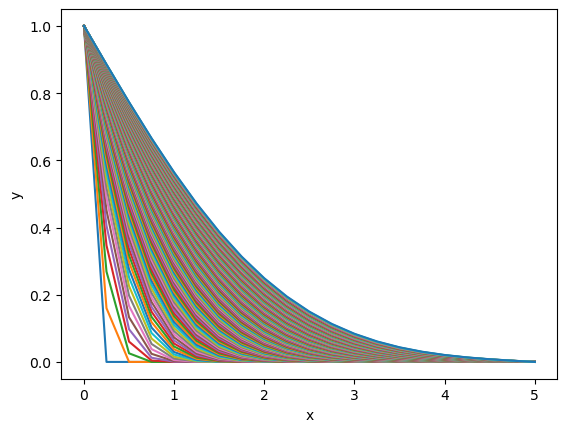

In [6]:
D = 0.1  # diffusion constant
dt = 0.1 # time step
ts = 15.   # time for solution
y = euler(diff1D, y0, dt, int(ts/dt), (x, D))  
plt.plot(x, y.T)
plt.xlabel("x"); plt.ylabel("y");

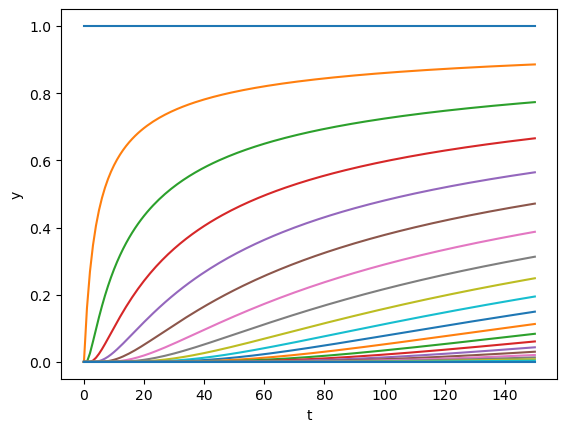

In [7]:
plt.plot(y)
plt.xlabel("t"); plt.ylabel("y");

Let us try a finer spatial division

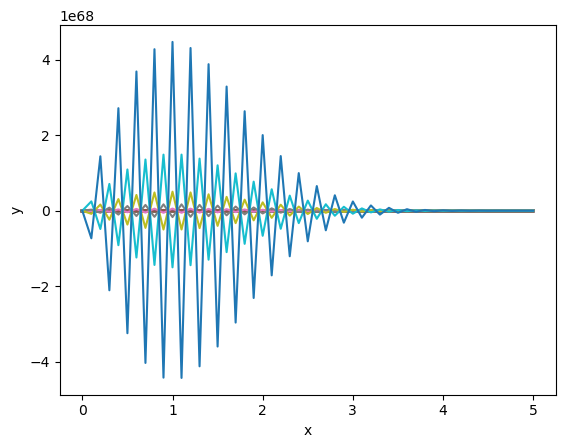

In [8]:
N = 50
dt = 0.1
x = np.linspace(0, Lx, N+1)
y0 = np.zeros_like(x)  # initial condition
y0[0] = 1   # 1 at left end
D = 0.1  # diffusion constant
y = euler(diff1D, y0, dt, int(ts/dt), (x, D))  
plt.plot(x, y.T)
plt.xlabel("x"); plt.ylabel("y");

### Stability
For an accurate solution, $\Delta x$ have to be small. But making $\Delta x$ small can make the ODE *stiff* such that solution can be unstable.  
It is known that stable solution by Euler method requires
$$ \Delta t \le \frac{\Delta x^2}{2D}. $$

## By odeint
The above stability issue can be worked around by using an ODE library that implements automatic time step adaptation, such as odeint.

In [9]:
from scipy.integrate import odeint

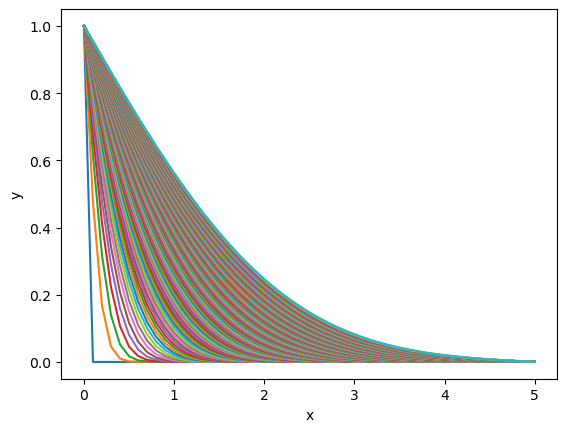

In [10]:
Lx = 5   # length
N = 50
x = np.linspace(0, Lx, N+1)
y0 = np.zeros_like(x)  # initial condition
y0[0] = 1
D = 0.1  # diffusion constant
dt = 0.1
t = np.arange(0, ts, dt)
y = odeint(diff1D, y0, t, (x, D))
p = plt.plot(x, y.T)
plt.xlabel("x"); plt.ylabel("y");

Let us see the case with an input.

In [11]:
def pulse(y, x, t):
    """1 for 1<x<2 at 1<t<2"""
    return (1<x)*(x<2)*(1<t)*(t<2)*1.

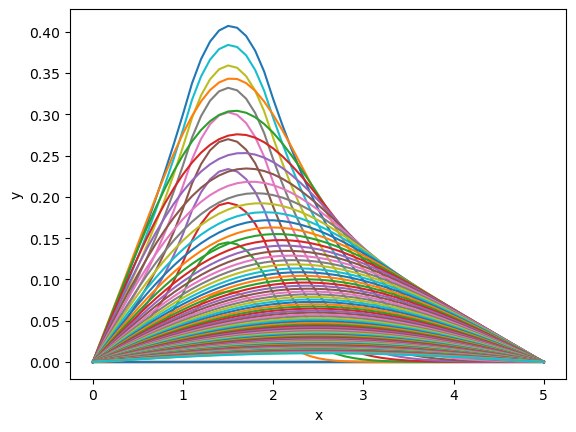

In [12]:
N = 50
x = np.linspace(0, Lx, N+1)
y0 = np.zeros_like(x)  # initial condition
ts = 10
t = np.arange(0, ts, dt)
y = odeint(diff1D, y0, t, (x, 1, pulse))
p = plt.plot(x, y.T)
plt.xlabel("x"); plt.ylabel("y");

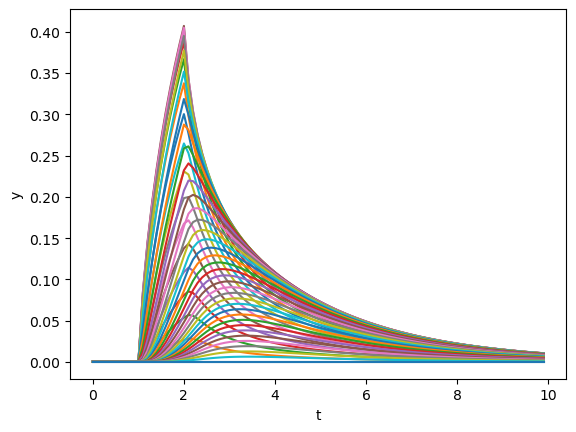

In [13]:
# plot of each point in time
p = plt.plot(t, y)
plt.xlabel("t"); plt.ylabel("y");

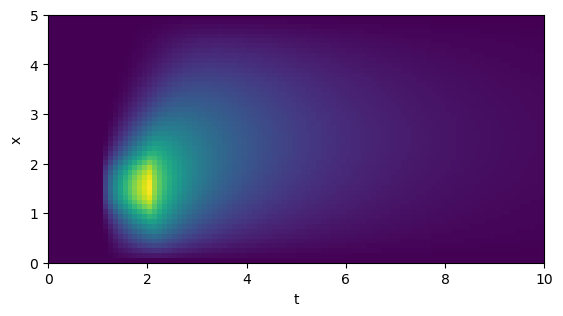

In [14]:
# plot in space and time
plt.imshow(y.T, origin='lower', extent=(0, ts, 0, Lx))
plt.xlabel("t"); plt.ylabel("x");

## 3D plot and animation

In [15]:
%matplotlib notebook

In [16]:
# plot in 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
T, X = np.meshgrid(t, x)
ax.plot_surface(T, X, y[:,:N+1].T, cmap='viridis')
plt.xlabel("t"); plt.ylabel("x"); 

<IPython.core.display.Javascript object>

In [17]:
from matplotlib import animation

In [18]:
fig = plt.figure()
frames = []  # prepare frame
for i, ti in enumerate(t):
    p = plt.plot(x, y[i])
    plt.xlabel("x"); plt.ylabel("y");
    frames.append(p)    
anim = animation.ArtistAnimation(fig, frames, interval = 10)

<IPython.core.display.Javascript object>

## Boundary Conditions

As briefly mentioned above, there are two typical ways of specifying the *boundary condition*:

* Dirichlet boundary condition: the value $y(x_0,t)=y_0$ or  $y(x_N,t)=y_N$
    - concentration at an open end of a tube to a water bath.
    - voltage of an electric cable attached to the ground or a strong battery.

* Neumann boundary condition: the derivative $\left.\frac{\partial y(x,t)}{\partial x}\right|_{x_0}=y'_0$ or
 $\left.\frac{\partial y(x,t)}{\partial x}\right|_{x_N}=y'_N$
    - concentration at a closed end of a tube (no molecular flow).
    - voltage at a dead end of an electric cable.

We already implemented Dirichlet boundary condition in `diff1D()`.

Let us implement a Neumann boundary condition at the right end  $\left.\frac{\partial y(x,t)}{\partial x}\right|_{x_N}=0$ and see the difference.

A simple way is to use a one-sided differentiation
$$ \frac{\partial y}{\partial x} \simeq \frac{y_{N+1}-y_{N}}{\Delta x}=0$$
which reduces to $y_{N+1}=y_{N}$ and 
$$ \frac{dy_N}{dt} = D \frac{y_{N-1} - y_N}{\Delta x^2} + g(y,x,t).$$

A better way is to use a symmetric differentiation
$$ \frac{\partial y}{\partial x} \simeq \frac{y_{N+1}-y_{N-1}}{2\Delta x}=0$$
which reduces to $y_{N+1}=y_{N-1}$ and 
$$ \frac{dy_N}{dt} = 2D \frac{y_{N-1} - y_N}{\Delta x^2} + g(y,x,t).$$

In [19]:
def diff1DN(y, t, x, D, inp=None):
    """1D Diffusion equaiton with boundary conditions
    y_0=0 on the left and dy/dx|x_N=0 on the right end.
    y: state vector
    t: time
    x: positions
    D: diffusion coefficient
    input: function(y,x,t)"""
    # spatial step
    dx = x[1] - x[0]
    # shift array to left and right
    d2ydx2 = (y[:-2] -2*y[1:-1] + y[2:])/dx**2
    # Dirichlet on the left, Neumann on the right end
    d2ydx2 = np.hstack((0, d2ydx2, 2*(y[-2] - y[-1])/dx**2))
    if inp == None:
        return(D*d2ydx2)
    else:
        return(D*d2ydx2 + inp(y, x, t))

In [20]:
N = 100
x = np.linspace(0, 1, N+1)
y0 = np.zeros_like(x)  # initial condition
y0 = np.sin(np.pi*x)
t = np.arange(0, 1, 0.01)
y = odeint(diff1DN, y0, t, (x, 1))
plt.figure()
plt.plot(x, y.T)
plt.xlabel("x"); plt.ylabel("y");

<IPython.core.display.Javascript object>

## Wave Equation

PDE with a second-order dynamics can represent traveling waves. The *wave equation* has the standard form
$$ \frac{\partial^2 u}{\partial t^2} + d\frac{\partial u}{\partial t} = c^2 \frac{\partial^2 u}{\partial x^2}$$
where $c$ is the wave speed and $d$ is the decay rate.

We convert the second-order system to a set of first order systems by consiering a vector $y=(u,v)$ representing the amplitude $u$ and its change rate $v$:
$$ \frac{\partial u}{\partial t} = v $$
$$ \frac{\partial v}{\partial t} = c^2 \frac{\partial^2 u}{\partial x^2} - dv $$

In [21]:
def wave1D(y, t, x, c, d, inp=None):
    """1D wave equaiton with constant boundary
    y: state vector hstack(u, v)
    t: time
    x: positions
    c: wave speed
    input: function(y,x,t)"""
    n = int(len(y)/2)
    u, v = y[:n], y[n:]
    dx = x[1] - x[0]
    # finite different approximation
    d2udx2 = (u[:-2] -2*u[1:-1] + u[2:])/dx**2
    d2udx2 = np.hstack((0, d2udx2, 0))  # add 0 to both ends
    if inp == None:
        return np.hstack((v, c**2*d2udx2 - d*v))
    else:
        return np.hstack((v, c**2*d2udx2 - d*v + inp(y, x, t)))

In [22]:
Lx = 10
N = 100
x = np.linspace(0, Lx, N+1)
y0 = np.zeros(2*(N+1))  # initial condition
c = 1.  # wave speed
d = 0.1
ts = 30
dt = 0.1
t = np.arange(0, ts, dt)
y = odeint(wave1D, y0, t, (x, c, d, pulse))
plt.figure()
plt.plot(x, y[:,:N+1].T)  # only first dimension
plt.xlabel("x"); plt.ylabel("u"); 

<IPython.core.display.Javascript object>

In [23]:
# plot in 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
T, X = np.meshgrid(t, x)
ax.plot_surface(T, X, y[:,:N+1].T, cmap='viridis')
plt.xlabel("t"); plt.ylabel("x"); 

<IPython.core.display.Javascript object>

In [24]:
fig = plt.figure()
frames = []  # prepare frame
for i, ti in enumerate(t):
    p = plt.plot(x, y[i,:N+1])
    plt.xlabel("x"); plt.ylabel("y");
    frames.append(p)    
anim = animation.ArtistAnimation(fig, frames, interval = 10)

<IPython.core.display.Javascript object>

/Users/doya/miniforge3/lib/python3.9/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


## Reaction-Diffusion Equation
Linear waves can decay, reflect, and overlay.  
Some nonlinear waves, like neural spike, can travel without decaying.
FitzHugh-Nagumo model can be embedded in a diffusive axon model
$$ \frac{\partial v}{\partial t} = v - \frac{v^3}{3} - w + D\frac{\partial^2 v}{\partial x^2} + I $$
$$ \frac{\partial w}{\partial t} = \phi (v + a - bw) $$

In [25]:
def fhnaxon(y, t, x, inp, D=1, a=0.7, b=0.8, phi=0.08):
    """FitzHugh-Nagumo axon model
    y: state vector hstack(v, w)
    t: time
    x: positions
    I: input current
    D: diffusion coefficient
    """
    n = int(len(y)/2)
    v, w = y[:n], y[n:]
    # finite difference approximation
    d2vdx2 = (v[:-2] -2*v[1:-1] + v[2:])/(x[1] - x[0])**2
    d2vdx2 = np.hstack((0, d2vdx2, 0))  # add 0 to both ends
    dvdt = v - v**3/3 - w + D*d2vdx2 + inp(y, x, t)
    dwdt = phi*(v + a -b*w)
    return(np.hstack((dvdt, dwdt)))

In [26]:
def pulse2(y, x, t):
    """1 for 5<x<10 at 5<t<10"""
    return (5<x)*(x<10)*(5<t)*(t<10)

In [27]:
Lx = 50
N = 100
x = np.linspace(0, Lx, N+1)
y0 = np.zeros(2*(N+1))  # initial condition
y0[0:N+1] = -2  # reset 
ts = 50
dt = 0.5
t = np.arange(0, ts, dt)
y = odeint(fhnaxon, y0, t, (x, pulse2))
plt.figure()
p = plt.plot(x, y[:,:N+1].T) # plot in space
plt.xlabel("x"); plt.ylabel("v");

<IPython.core.display.Javascript object>

In [28]:
plt.figure()
plt.imshow(y[:,:N+1].T, origin='lower', extent=(0, ts, 0, Lx))
plt.xlabel("t"); plt.ylabel("x");

<IPython.core.display.Javascript object>

In [29]:
# plot in 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
T, X = np.meshgrid(t, x)
ax.plot_surface(T, X, y[:,:N+1].T, cmap='viridis')
plt.xlabel("t"); plt.ylabel("x"); 

<IPython.core.display.Javascript object>

In [30]:
fig = plt.figure()
frames = []  # prepare frame
for i, ti in enumerate(t):
    p = plt.plot(x, y[i,:N+1])
    plt.xlabel("x"); plt.ylabel("y");
    frames.append(p)    
anim = animation.ArtistAnimation(fig, frames, interval = 10)

<IPython.core.display.Javascript object>

/Users/doya/miniforge3/lib/python3.9/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


## PDE in 2D space
We can also model dynamics in two or higher dimension spate.

The diffusion equation of a variable $y(x_1,x_2,t)$ in the 2D space is given by:
$$\frac{\partial y}{\partial t} = D\frac{\partial^2 y}{\partial x_1^2} + D\frac{\partial^2 y}{\partial x_2^2} + g(y, x, t)$$

Using the Laplace operator (or Laplacian):
$$\nabla^2 = \frac{\partial^2}{\partial x_1^2} + \frac{\partial^2}{\partial x_2^2}$$
the diffusion equation is represented as
$$\frac{\partial y}{\partial t} = D\nabla^2 y + g(y, x, t)$$

### Diffusion equation in 2D space

In [31]:
def diff2D(y, t, x, D, inp=0):
    """1D Diffusion equaiton with constant boundary condition
    y: states at (x0, x1)
    t: time
    x: positions (x0, x1): transposed meshgrid
    D: diffusion coefficient
    inp: function(y,x,t) or number"""
    n = x.shape[:2]  # grid size (n0, n1)
    nn = n[0]*n[1]  # grid points n0*n1
    y = y.reshape(n)  # linear to 2D
    dx = [x[1,0,0]-x[0,0,0], x[0,1,1]-x[0,0,1]]  # space step
    # Laplacian with cyclic boundary
    Ly = (np.roll(y,-1,0) + np.roll(y,1,0) + np.roll(y,-1,1) + np.roll(y,1,1) - 4*y)/dx[0]**2
    Ly[0,:] = Ly[-1:0] = Ly[:,0] = Ly[:,-1] = 0  # Dirichlet boundary
    dydt = D*Ly + (inp(y,x,t) if callable(inp) else inp)
    return dydt.ravel()

In [32]:
def pulse3(y, x, t):
    """1 for 0.2<x0<0.3 at 1<t<2"""
    return (0.2<x[0])*(x[0]<0.3)*(0.4<x[1])*(x[1]<0.6)*(1<t)*(t<2)

In [33]:
L = 10
N = 20
X = np.meshgrid(np.linspace(0,L,N), np.linspace(0,L,N))
x = np.array(X).transpose(2,1,0)  # (x0,x1) in last dimention
y0 = np.zeros((N,N))  # initial condition
y0[2:4,5:8] = 1  # 
ts = 5
dt = 0.1
t = np.arange(0, ts, dt)

In [34]:
y = odeint(diff2D, y0.ravel(), t, (x, 1))
plt.figure(figsize=(8,3))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(y[5*i].reshape(N,N).T)
    plt.title('t={:1.1f}'.format(t[5*i]))
plt.tight_layout()

<IPython.core.display.Javascript object>

In [35]:
fig = plt.figure()
frames = []  # prepare frame
for i, ti in enumerate(t):
    p = plt.imshow(y[i].reshape(N,N).T)
    frames.append([p])    
anim = animation.ArtistAnimation(fig, frames, interval = 10)
plt.xlabel("x1"); plt.ylabel("x2");

<IPython.core.display.Javascript object>

In [36]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
frames = []  # prepare frame
for i, ti in enumerate(t):
    p = ax.plot_surface(X[0], X[1], y[i].reshape(N,N).T, cmap='viridis')
    frames.append([p])    
anim = animation.ArtistAnimation(fig, frames, interval = 10)
plt.xlabel("x1"); plt.ylabel("x2");

<IPython.core.display.Javascript object>

## PDE libraries

Solution of PDE is computationally intensive, especially in 2D or higher dimensional space. For practical computation, it is better to use specialized libraries for solving PDEs, such as:

* py-pde: https://py-pde.readthedocs.io
* FiPy: https://www.ctcms.nist.gov/fipy
* FEniCS: https://fenicsproject.org
